In [84]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import random


In [58]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./board/assignment_3')

# Tracking model training with TensorBoard
In the previous example, we simply printed the model’s running loss every 2000 iterations. Now, we’ll instead log the running loss to TensorBoard, along with a view into the predictions the model is making via the plot_classes_preds function.

In [59]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [60]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

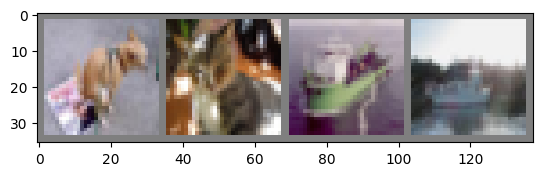

dog   cat   ship  ship 


In [61]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  

# show images
imshow(torchvision.utils.make_grid(images)) # 將多個圖像合併成一個網格以便顯示。
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



1. Train the same network as in the PyTorch CNN tutorial.
2. Change now the network architecture as follows and train the network:
1. Conv layer with 3x3 kernel and depth = 8, ReLu activation
2. Conv layer with 3x3 kernel and depth = 16, ReLu activation
3. Max pooling with 2x2 kernel
4. Conv layer with 3x3 kernel and depth = 32, ReLu activation
5. Conv layer with 3x3 kernel and depth = 64, ReLu activation
6. Max pooling with 2x2 kernel
7. Fully connected with 4096 nodes, ReLu activation
8. Fully connected with 1000 nodes, ReLu activation
9. Fully connected with 10 nodes, no activation

In [62]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [63]:
import torch.nn as nn

class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)  # 第1層：3x3 kernel and depth = 8
        self.conv2 = nn.Conv2d(8, 16, 3)  # 第2層：3x3 kernel and depth = 16
        self.pool = nn.MaxPool2d(2, 2)  # 第3層：Max pooling with 2x2 kernel
        self.conv3 = nn.Conv2d(16, 32, 3)  # 第4層：3x3 kernel and depth = 32
        self.conv4 = nn.Conv2d(32, 64, 3)  # 第5層：3x3 kernel and depth = 64
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)  # 第6層：Fully connected with 4096 nodes
        self.fc2 = nn.Linear(4096, 1000)  # 第7層：Fully connected with 1000 nodes
        self.fc3 = nn.Linear(1000, 10)  # 第8層：Fully connected with 10 nodes

    def forward(self, x):
        x = F.relu(self.conv1(x))  # ReLu activation
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = NewNet()


In [64]:
net.to(device)

NewNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [65]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [66]:
import time
start_time = time.time()

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs.to(device)
        loss = criterion(outputs, labels)
        loss.to(device)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f} time elapsed: {round((time.time() - start_time) / 60)} min')
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 200,
                            epoch * len(trainloader) + i)
            running_loss = 0.0

print(f'Finished Training. Total elapsed time: {round((time.time() - start_time) / 60, 1)} min')

[1,   200] loss: 2.303 time elapsed: 0 min
[1,   400] loss: 2.304 time elapsed: 0 min
[1,   600] loss: 2.302 time elapsed: 0 min
[1,   800] loss: 2.302 time elapsed: 0 min
[1,  1000] loss: 2.303 time elapsed: 0 min
[1,  1200] loss: 2.302 time elapsed: 0 min
[1,  1400] loss: 2.301 time elapsed: 0 min
[1,  1600] loss: 2.299 time elapsed: 0 min
[1,  1800] loss: 2.301 time elapsed: 0 min
[1,  2000] loss: 2.300 time elapsed: 0 min
[1,  2200] loss: 2.297 time elapsed: 0 min
[1,  2400] loss: 2.294 time elapsed: 0 min
[1,  2600] loss: 2.284 time elapsed: 0 min
[1,  2800] loss: 2.238 time elapsed: 1 min
[1,  3000] loss: 2.112 time elapsed: 1 min
[1,  3200] loss: 2.058 time elapsed: 1 min
[1,  3400] loss: 2.039 time elapsed: 1 min
[1,  3600] loss: 1.977 time elapsed: 1 min
[1,  3800] loss: 2.021 time elapsed: 1 min
[1,  4000] loss: 1.933 time elapsed: 1 min
[1,  4200] loss: 1.922 time elapsed: 1 min
[1,  4400] loss: 1.902 time elapsed: 1 min
[1,  4600] loss: 1.836 time elapsed: 1 min
[1,  4800] 

In [67]:
# # Use CPU 
# device = torch.device("cpu")
# net.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# import time
# start_time = time.time()

# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         # inputs, labels = data
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         outputs.to(device)
#         loss = criterion(outputs, labels)
#         loss.to(device)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 200 == 199:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f} time elapsed: {round((time.time() - start_time) / 60)} min')
            
#             running_loss = 0.0

# print(f'Finished Training. Total elapsed time: {round((time.time() - start_time) / 60, 1)} min')

# CPU vs GPU Training Time
- GPU: 4.65 min 
- CPU: 7.6 min

Let's save our trained model:

In [68]:
PATH = './model/cifar_net.pth'
# torch.save(net.state_dict(), PATH)

# Run the tensorboard server
- Now running `tensorboard --logdir=runs` 
- from the command line and then navigating to http://localhost:6006 should show the following.

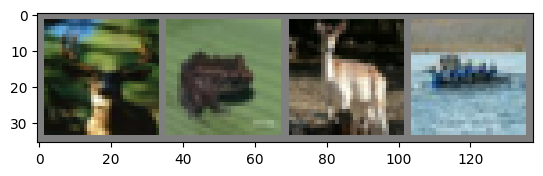

deer  frog  deer  ship 


In [69]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  

# show images
imshow(torchvision.utils.make_grid(images)) # 將多個圖像合併成一個網格以便顯示。
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [70]:
net = NewNet()
net.load_state_dict(torch.load(PATH)) # load the weights from the saved file

<All keys matched successfully>

In [86]:
correct = 0
total = 0

class_correct = [0] * len(classes)  # 用來記錄每個類別的正確預測數
class_total = [0] * len(classes)    # 用來記錄每個類別的總樣本數

# for saving misclassified images
all_errors = []


# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images) 

        # select top 3 predictions
        _, predicted = torch.topk(outputs, 3, dim=1)
        
        # check if predicted labels are in true labels
        for i in range(len(labels)):
            print(f'Predicted: {predicted[i]} Actual: {labels[i]} \t Correct: {labels[i] in predicted[i]}')
            # count total number of samples in each class
            total += 1
            class_total[labels[i]] += 1

            # check if predicted labels are in true labels
            if labels[i] in predicted[i]:
                correct += 1
                class_correct[labels[i]] += 1
            else:
                # 將錯誤的圖片、輸出和標籤記錄下來
                all_errors.append((images[i], outputs[i], labels[i]))

# 計算每個類別的準確率
class_accuracies = [class_correct[i] / class_total[i] for i in range(len(classes))]

# 計算並列印新的準確度
accuracy = correct / total

Predicted: tensor([3, 5, 2]) Actual: 3 	 Correct: True
Predicted: tensor([8, 0, 1]) Actual: 8 	 Correct: True
Predicted: tensor([8, 1, 9]) Actual: 8 	 Correct: True
Predicted: tensor([8, 0, 1]) Actual: 0 	 Correct: True
Predicted: tensor([4, 2, 6]) Actual: 6 	 Correct: True
Predicted: tensor([6, 3, 5]) Actual: 6 	 Correct: True
Predicted: tensor([1, 9, 5]) Actual: 1 	 Correct: True
Predicted: tensor([2, 6, 4]) Actual: 6 	 Correct: True
Predicted: tensor([3, 5, 2]) Actual: 3 	 Correct: True
Predicted: tensor([1, 8, 9]) Actual: 1 	 Correct: True
Predicted: tensor([0, 4, 2]) Actual: 0 	 Correct: True
Predicted: tensor([9, 1, 8]) Actual: 9 	 Correct: True
Predicted: tensor([5, 3, 4]) Actual: 5 	 Correct: True
Predicted: tensor([7, 4, 5]) Actual: 7 	 Correct: True
Predicted: tensor([9, 1, 8]) Actual: 9 	 Correct: True
Predicted: tensor([8, 3, 1]) Actual: 8 	 Correct: True
Predicted: tensor([5, 3, 7]) Actual: 5 	 Correct: True
Predicted: tensor([3, 7, 2]) Actual: 7 	 Correct: True
Predicted:

In [87]:
print(f'Accuracy on test data (top-3): {100 * accuracy:.2f}%')

# print each class accuracy
for i in range(len(classes)):
    print(f'Accuracy for class {classes[i]}: {100 * class_accuracies[i]:.2f}%')

Accuracy on test data (top-3): 91.60%
Accuracy for class plane: 89.50%
Accuracy for class car: 96.30%
Accuracy for class bird: 85.20%
Accuracy for class cat: 91.80%
Accuracy for class deer: 92.40%
Accuracy for class dog: 91.40%
Accuracy for class frog: 88.30%
Accuracy for class horse: 91.50%
Accuracy for class ship: 96.20%
Accuracy for class truck: 93.40%


In [89]:
# print the number of misclassified images
print(f'Total misclassified images: {len(all_errors)}')

Total misclassified images: 840


In [103]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [121]:

def plot_classes_preds(all_errors):
    # randomly select 5 misclassified images
    random_errors = random.sample(all_errors, 5)

    # 創建一個大的 matplotlib 圖表，包含一行 5 列的子圖
    # create a big plot with subplots per row and per column
    fig = plt.figure(figsize=(12, 10))

    for idx, (image, output, label) in enumerate(random_errors):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(image, one_channel=True)
        preds = torch.topk(output, 3, dim=0).indices  # find top 3 
        pred_classes = [classes[p] for p in preds]
        ax.set_title("\n(label: {0})\n({1})".format(
            classes[label],
            ", ".join(pred_classes)),
            color="red")

    return fig


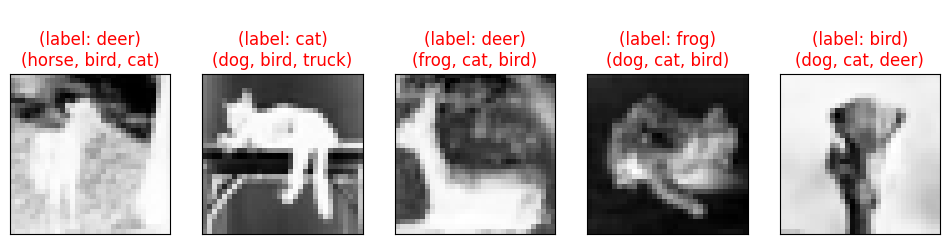

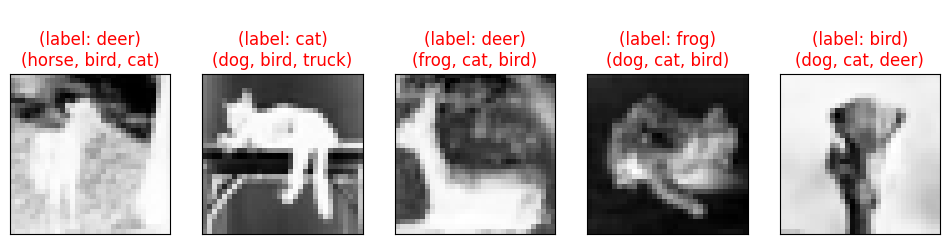

In [122]:
plot_classes_preds(all_errors)

In [123]:
fig = plot_classes_preds(all_errors)
writer.add_figure("predictions vs. actuals", fig)

In [125]:
%tensorboard --logdir=board

Reusing TensorBoard on port 6006 (pid 88332), started 0:01:01 ago. (Use '!kill 88332' to kill it.)